# Ввод библиотек и данных

In [196]:
!pip3.11 install --upgrade stopwordsiso          # ← работает

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# Код для оценки и визуализации метрик качества поиска
import math
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [27]:
import json, re, unicodedata, faiss, numpy as np, pandas as pd
from sentence_transformers import SentenceTransformer
from stopwordsiso import stopwords
from bs4 import BeautifulSoup


In [154]:
from groq import Groq
import pickle
import os
import faiss
import numpy as np
import pandas as pd
import json
import torch
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor,
    CLIPModel,
    BlipProcessor,
    BlipForConditionalGeneration,
)
import faiss
from typing import List, Tuple

# --- текстовый RAG -----------------------------------------------------------
EMBEDDING_MODEL  = "paraphrase-multilingual-MiniLM-L12-v2"
FAISS_INDEX_PATH = "/Applications/Study/Diploma/news_date.faiss"
NEWS_DATA_PATH   = "/Applications/Study/Diploma/gpt_news.json"
TOP_K            = 5                               # кол-во текстовых чанков

# --- мультимодальный (изображения) -------------------------------------------
CLIP_MODEL_NAME      = "openai/clip-vit-large-patch14"
BLIP_MODEL_NAME      = "Salesforce/blip-image-captioning-large"
CLIP_MAX_TOKENS      = 77

CLIP_INDEX_PATH      = "/Applications/Study/Diploma/clip_index_last.faiss"
BLIP_INDEX_PATH      = "/Applications/Study/Diploma/blip_index_last.faiss"
CLIP_VALID_PATHS_PKL = "/Applications/Study/Diploma/clip_valid_paths.pkl"
BLIP_CAPTIONS_PKL    = "/Applications/Study/Diploma/blip_captions.pkl"
TOP_IMAGE_K          = 5 

# ---------------------------------------------------------------------------
model = SentenceTransformer(EMBEDDING_MODEL)

text_index = faiss.read_index(FAISS_INDEX_PATH)
blip_index = faiss.read_index(BLIP_INDEX_PATH)
clip_index = faiss.read_index(CLIP_INDEX_PATH)

with open(NEWS_DATA_PATH, "r", encoding="utf-8") as f:
    _data = json.load(f)
df = pd.DataFrame(_data)
#news_texts: List[str] = _data if isinstance(_data, list) else _data.get("text", [])

# --- CLIP & BLIP -------------------------------------------------------------
print("⏳ Загружаю CLIP и BLIP – это займёт 1–2 мин на CPU …")
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
clip_model     = CLIPModel.from_pretrained(CLIP_MODEL_NAME)

blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_NAME)
blip_model     = BlipForConditionalGeneration.from_pretrained(BLIP_MODEL_NAME)
#blip_index     = faiss.read_index(BLIP_INDEX_PATH)

clip_tokenizer = clip_processor.tokenizer          # нужен для обрезки запросов
#clip_index     = faiss.read_index(CLIP_INDEX_PATH)
print("⏳ Загрузил CLIP и BLIP ")
import pickle
with open(CLIP_VALID_PATHS_PKL, "rb") as f:
    clip_valid_paths: List[str] = pickle.load(f)
with open(BLIP_CAPTIONS_PKL, "rb") as f:
    blip_captions: List[str] = pickle.load(f)

# --- Groq LLM ---------------------------------------------------------------
os.environ["GROQ_API_KEY"] = "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"
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

⏳ Загружаю CLIP и BLIP – это займёт 1–2 мин на CPU …
⏳ Загрузил CLIP и BLIP 


In [157]:
# Показывать все столбцы
pd.set_option('display.max_columns', None)
# Не обрезать ширину таблицы по общему числу символов
pd.set_option('display.width', None)
# Показывать весь текст в ячейках (не обрезать по ширине)
pd.set_option('display.max_colwidth', None)


In [ ]:


# 1. Загрузка
with open("news_data2.json", encoding="utf-8") as f:
    raw = json.load(f)
df = pd.DataFrame(raw)
df.head(1)


In [76]:

# 2. Очистка пустых / None
df["text"] = df["text"].fillna("").astype(str)
df = df[df["text"].str.strip().ne("")].reset_index(drop=True)

# 3. Предобработка
ru_stop = stopwords("ru")
def clean(text: str) -> str:
    text = BeautifulSoup(text, "html.parser").get_text(" ", strip=True)
    text = unicodedata.normalize("NFKC", text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    tokens = [t for t in text.split() if t not in ru_stop]
    return " ".join(tokens)
df["clean_text"] = df["text"].map(clean)

# 4. Фильтрация коротких новостей
df["word_count"] = df["clean_text"].str.split().apply(len)
df = df[df["word_count"] > 7].reset_index(drop=True)
df = df.drop(columns=["word_count"])

months = {
    '01': 'января', '02': 'февраля', '03': 'марта', '04': 'апреля',
    '05': 'мая', '06': 'июня', '07': 'июля', '08': 'августа',
    '09': 'сентября', '10': 'октября', '11': 'ноября', '12': 'декабря'
}
df['time_'] = df['time'].str.replace(
    r'(\d{2})\.(\d{2})\.\d{4}',
    lambda m: f"{int(m.group(1))} {months[m.group(2)]}",
    regex=True
)

df["clean_text"] = df["time_"] + " " + df["clean_text"]

df.head(1)

,category,channel,message_id,time,text,image_path,clean_text,time_
0,General news,@rian_ru,291023,25.04.2025,Разведка Индии на фоне обострения отношений с Пакистаном предупредила о возможности новых терактов в Джамму и Кашмире,,25 апреля разведка индии фоне обострения отношений пакистаном предупредила возможности новых терактов джамму кашмире,25 апреля


In [200]:
news_image_text = df[
    df["image_path"].notna()            # не NaN/None
    & df["image_path"].ne("")           # не пустая строка
]
news_image_text.head(1)

,category,channel,message_id,time,text,image_path,clean_text,time_
11,General news,@rian_ru,289957,18.04.2025,"Глава МИД непризнанной Приднестровской Молдавской Республики Виталий Игнатьев рассказал РИА Новости об отношениях Кишинева с Тирасполем и не только. Главное: \n\n🔹Кишинев уклоняется от переговоров с Тирасполем, чтобы продолжить блокадные меры и усиление давления на Приднестровье.\n\n🔹Молдавия все чаще использует правовые механизмы в политических целях.\n\n🔹Для вывоза или уничтожения боеприпасов в Колбасне надо выяснить параметры техногенной и экологической безопасности.\n\n🔹Высылка российских дипломатов из Молдавии осложняет взаимодействие и ухудшает атмосферу диалога Кишинева и Тирасполя.\n\n🔹Приднестровье рассчитывает, что ЕС будет стимулировать Кишинев к переговорам с Тирасполем, а не содействовать милитаризации Молдавии.",/Applications/Study/Diploma/images/rian_ru_289957.jpg,18 апреля глава мид непризнанной приднестровской молдавской республики виталий игнатьев рассказал риа новости отношениях кишинева тирасполем главное кишинев уклоняется переговоров тирасполем продолжить блокадные меры усиление давления приднестровье молдавия использует правовые механизмы политических целях вывоза уничтожения боеприпасов колбасне выяснить параметры техногенной экологической безопасности высылка российских дипломатов молдавии осложняет взаимодействие ухудшает атмосферу диалога кишинева тирасполя приднестровье рассчитывает ес стимулировать кишинев переговорам тирасполем содействовать милитаризации молдавии,18 апреля


In [201]:
news_image_paths = df[
    df["image_path"].notna()            # не NaN/None
    & df["image_path"].ne("")           # не пустая строка
]
news_image_paths = list(news_image_paths["image_path"])

In [202]:
len(news_image_paths[0])

53

In [203]:
# Преобразуем Series в обычный список
texts = df["clean_text"].tolist()

# Сформируем нужную структуру
data = {
    "clean_text": texts
}

# Сохраним в файл в человекочитаемом виде с Unicode напрямую
with open("gpt_news.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

# Оценка

## Средние показатели MAP, NDCG и MRR для text index

In [ ]:
full_match_queries = [
    "Когда срок моратория на удары по энергообъектам истек?",
    "Какое видео показало УФСБ ЛНР об эвакуации австралийского наёмника?",
    "Какая награда досталась Никите Кучерову по итогам регулярного сезона НХЛ?",
    "Кто назвала празднование 9 мая в Киеве проявлением театра абсурда?",
    "Когда приложение банка стало снова доступно в App Store?",
    "Сколько беспилотников уничтожили силы ПВО под Запорожской областью?",
    "Какая партия назвала событие в кишинёвском аэропорту актом духовного террора?",
    "Где локализован пожар на складе лакокрасочной продукции в Челябинской области?",
    "До какого срока продлили уплату налогов организациям Краснодарского края?",
    "Когда Оскар Чарльз Агустус Дженкинс прибыл в Украину?",
    "Кто сообщил о приостановке продажи российской дочки Raiffeisen?",
    "Кто рассказал о высылке российских дипломатов из Молдавии и блокаде Приднестровья?",
    "Каков средний возраст матери в России по данным ЗАГС на 2025 год?",
    "Когда Украина и США начнут раунд переговоров по соглашению об ископаемых?",
    "Как называется новый фильм «Звёздные войны», где снимется Раян Гослинг?",
    "Кто заявил, что ЕС поддерживает операционное взаимодействие с движением «Талибан»?",
    "Сколько беспилотников сбила российская ПВО в Курской области?",
    "Кто назвала киевский праздничный шабаш проявлением цинизма?",
    "Какой документ между Киевом и Вашингтоном подтвердил намерение заключить сделку по ископаемым?",
    "Кто заявил о пригодности пляжей Крыма и Севастополя для курортного сезона?"
]

partial_match_queries = [
    "Когда вводили и когда снимали ограничения на вылеты в аэропортах?",
    "Какие подразделения участвовали в освобождении Калиново в ДНР?",
    "Где произошли пожары на складах лакокрасочных материалов и на центральном рынке?",
    "Что конфисковали у генерала Шамарина после приговора?",
    "Какие новости о задержании иностранных граждан сообщило ФСБ?",
    "Какие цифры называли по количеству уничтоженных украинских беспилотников?",
    "Какие партии комментировали срыв поездки епископа Маркелла?",
    "Какие заявления Пескова касались ударов по энергетическим объектам?",
    "Какие политические лидеры высказывались о конфликте в Украине?",
    "Какие документы подписали Киев и Вашингтон по ископаемым ресурсам?",
    "Какие меры поддержки бизнеса были приняты в Краснодарском крае?",
    "Какие религиозные события освещались в апрельских новостях?",
    "Какие авиарейсы ограничили в Саратове и Волгограде?",
    "Какие главы иностранных государств посещали Москву в апреле?",
    "Какие заявления Захаровой касались движения «Талибан» и ЕС?",
    "Какие транспортные ограничения вводились на Крымском мосту?",
    "Какие законы о «иноагентах» принимал Совет Федерации?",
    "Какие назначения сделали в Союзном государстве Россия–Беларусь?",
    "Какие темы поднимались на переговорах Путина с эмиром Катара?",
    "Какие инициативы по развитию космической отрасли упоминал Путин?"
]

no_match_queries = [
    "Какой будет курс евро к рублю в следующем месяце?",
    "Когда откроют новый терминал аэропорта Шереметьево?",
    "Какая команда выиграла Лигу чемпионов УЕФА в 2024 году?",
    "Кто стал обладателем «Оскара» за лучший фильм в 2025 году?",
    "Где находится самое большое месторождение нефти в мире?",
    "Сколько стоит биткоин сейчас?",
    "Какие новые модели Tesla выйдут в 2025 году?",
    "Когда наступит следующее полнолуние?",
    "Какое официальное население Москвы в 2024 году?",
    "Что такое квантовая запутанность?",
    "Как приготовить борщ по украинскому рецепту?",
    "Какие вакансии открыты в Яндексе?",
    "Где лучше отдохнуть на майские праздники?",
    "Когда стартует Чемпионат мира по футболу 2026 года?",
    "Кто написал роман «Война и мир»?",
    "Какие существуют виды машинного обучения?",
    "Какие есть курсы по Python для начинающих?",
    "Когда отмечается День России?",
    "Как обновить драйвер видеокарты?",
    "Где купить билеты на поезд Москва–Петербург?"
]

groups = {
    "Full match": full_match_queries,
    "Partial match": partial_match_queries,
    "No match": no_match_queries
}

In [ ]:
import json

# 1. Загружаем данные
with open("gpt_news.json", encoding="utf-8") as f:
    data = json.load(f)
docs = data["clean_text"]  # список всех документов



# 3. Для каждого запроса найдём индексы документов, где встречается хотя бы одно ключевое слово
def find_relevances(query, docs):
    # просто разбиваем запрос на слова >2 символов и ищем их
    keywords = [w.lower() for w in query.split() if len(w)>=7]
    hits = []
    for i, doc in enumerate(docs):
        text = doc.lower()
        if any(kw.rstrip('.,?') in text for kw in keywords):
            hits.append(i)
    return hits

full_match_relevances    = [find_relevances(q, docs) for q in full_match_queries]
partial_match_relevances = [find_relevances(q, docs) for q in partial_match_queries]
no_match_relevances      = [find_relevances(q, docs) for q in no_match_queries]

# 4. Собираем итоговый словарь
ground_truth = {
    "Full match":    full_match_relevances,
    "Partial match": partial_match_relevances,
    "No match":      no_match_relevances
}

# Посмотрим, например, первые 5 из Full match
for q, rel in zip(full_match_queries[:5], full_match_relevances[:5]):
    print(q, "->", rel)

Когда срок моратория на удары по энергообъектам истек? -> [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228

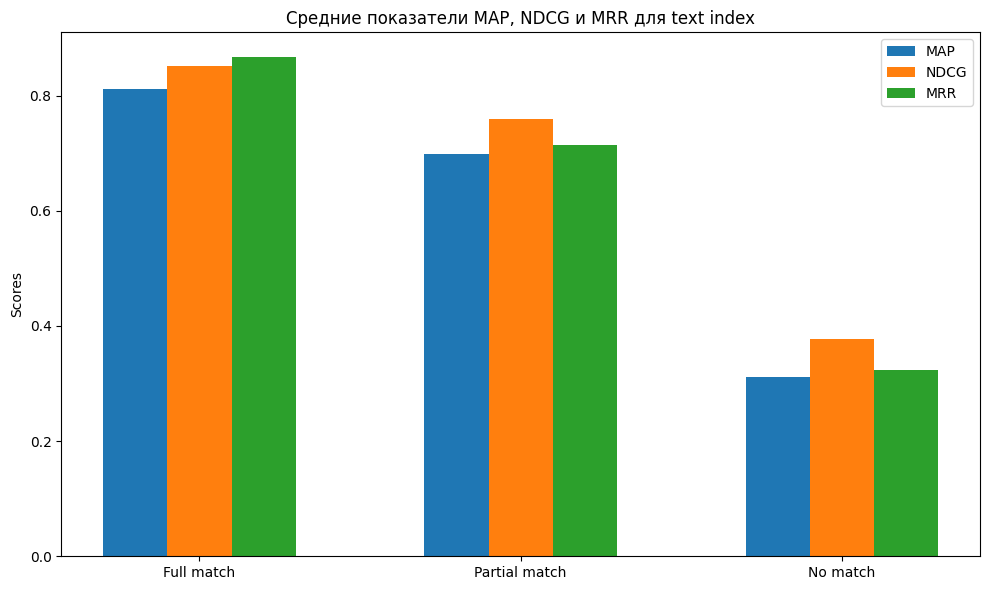

In [149]:
# 4. Метрики
def average_precision(rels):
    """rels — бинарный список 0/1, длина k"""
    ap, num_rel, cum_rel = 0.0, 0, 0
    for i, r in enumerate(rels):
        if r:
            num_rel += 1
            cum_rel += 1
            ap += cum_rel / (i + 1)
    return ap / num_rel if num_rel else 0.0

def ndcg_at_k(rels, k):
    dcg = rels[0] if rels else 0.0
    for i in range(1, min(len(rels), k)):
        dcg += rels[i] / math.log2(i + 2)
    ideal = sorted(rels, reverse=True)
    idcg = ideal[0] if ideal else 0.0
    for i in range(1, min(len(ideal), k)):
        idcg += ideal[i] / math.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0

def weighted_mrr(rels):
    for i, r in enumerate(rels):
        if r:
            return 1.0 / (i + 1)
    return 0.0

# 5. Оценка одного запроса
def evaluate_query(query: str, relevant_ids: list, k: int = 5):
    vec = encoder.encode(query, convert_to_numpy=True).astype('float32')
    faiss.normalize_L2(vec.reshape(1,-1))
    distances, indices = index.search(vec.reshape(1,-1), k)
    retrieved = indices[0]

    # бинарный вектор релевантности
    rels = [1 if doc_id in relevant_ids else 0 for doc_id in retrieved]

    # считаем метрики (AP/NDCG/MRR = 0, если нет ни одного релевантного)
    ap   = average_precision(rels)
    ndcg = ndcg_at_k(rels, k)
    mrr  = weighted_mrr(rels)
    return ap, ndcg, mrr

# 6. Пробегаем по всем группам и собираем
avg_metrics = {}
for group_name, queries in groups.items():
    aps, ndcgs, mrrs = [], [], []
    for q, gt in zip(queries, ground_truth[group_name]):
        ap, ndcg, mrr = evaluate_query(q, gt, k=5)
        # будем **исключать** пустые real из расчёта MAP и NDCG
        if gt:
            aps.append(ap)
            ndcgs.append(ndcg)
        else:
            # для No match добавляем нули, чтобы группировка осталась, но метрики упали
            aps.append(0.0)
            ndcgs.append(0.0)
        mrrs.append(mrr)

    avg_metrics[group_name] = {
        "MAP": np.mean(aps) if aps else 0.0,
        "NDCG": np.mean(ndcgs) if ndcgs else 0.0,
        "MRR": np.mean(mrrs) if mrrs else 0.0
    }

# 7. Визуализация (как у вас было)
labels    = list(avg_metrics.keys())
map_vals  = [avg_metrics[l]['MAP']  for l in labels]
ndcg_vals = [avg_metrics[l]['NDCG'] for l in labels]
mrr_vals  = [avg_metrics[l]['MRR']  for l in labels]

x = np.arange(len(labels))
w = 0.2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - w, map_vals,  w, label='MAP')
ax.bar(x,     ndcg_vals, w, label='NDCG')
ax.bar(x + w, mrr_vals,  w, label='MRR')

ax.set_ylabel('Scores')
ax.set_title('Средние показатели MAP, NDCG и MRR для text index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

## Средние показатели MAP, NDCG и MRR для CLIP-BLIP поиска по группам

In [ ]:
import json


def find_relevances(query: str, docs: pd.DataFrame) -> list:
    """
    Ищет в каждом row['clean_text'] хотя бы одно ключевое слово из query
    (только слова длиной >=7), возвращает список row['image_path'].
    """
    # Формируем список «длинных» ключевых слов
    keywords = [w.lower().strip('.,?') for w in query.split() if len(w) >= 3]
    hits = []
    # Проходим по всем строкам DataFrame
    for _, row in docs.iterrows():
        text = row['clean_text'].lower()
        if any(kw in text for kw in keywords):
            hits.append(row['image_path'])
    return hits

full_match_relevances    = [find_relevances(q, news_image_text) for q in full_match_queries]
partial_match_relevances = [find_relevances(q, news_image_text) for q in partial_match_queries]
no_match_relevances      = [find_relevances(q, news_image_text) for q in no_match_queries]

# 4. Собираем итоговый словарь
ground_truth_img = {
    "Full match": full_match_relevances,
    "Partial match": partial_match_relevances,
    "No match": no_match_relevances
}

# Посмотрим, например, первые 5 из Full match
for q, rel in zip(full_match_queries[:5], full_match_relevances[:5]):
    print(q, "->", rel)

Когда срок моратория на удары по энергообъектам истек? -> ['/Applications/Study/Diploma/images/rian_ru_289621.jpg', '/Applications/Study/Diploma/images/rian_ru_289572.jpg', '/Applications/Study/Diploma/images/sportrian_52287.jpg', '/Applications/Study/Diploma/images/sportrian_52153.jpg', '/Applications/Study/Diploma/images/sportrian_52114.jpg', '/Applications/Study/Diploma/images/sportsru_111284.jpg', '/Applications/Study/Diploma/images/football_nik_7868.jpg', '/Applications/Study/Diploma/images/football_nik_7726.jpg', '/Applications/Study/Diploma/images/hockey_vbros_19891.jpg', '/Applications/Study/Diploma/images/hockey_vbros_19861.jpg', '/Applications/Study/Diploma/images/hockey_vbros_19811.jpg', '/Applications/Study/Diploma/images/hockey_vbros_19773.jpg', '/Applications/Study/Diploma/images/hockey_vbros_19651.jpg', '/Applications/Study/Diploma/images/rianovostiAmerica_24844.jpg', '/Applications/Study/Diploma/images/politica_media_37511.jpg', '/Applications/Study/Diploma/images/polit

In [264]:
ground_truth_img

{'Full match': [['/Applications/Study/Diploma/images/rian_ru_289621.jpg',
   '/Applications/Study/Diploma/images/rian_ru_289572.jpg',
   '/Applications/Study/Diploma/images/sportrian_52287.jpg',
   '/Applications/Study/Diploma/images/sportrian_52153.jpg',
   '/Applications/Study/Diploma/images/sportrian_52114.jpg',
   '/Applications/Study/Diploma/images/sportsru_111284.jpg',
   '/Applications/Study/Diploma/images/football_nik_7868.jpg',
   '/Applications/Study/Diploma/images/football_nik_7726.jpg',
   '/Applications/Study/Diploma/images/hockey_vbros_19891.jpg',
   '/Applications/Study/Diploma/images/hockey_vbros_19861.jpg',
   '/Applications/Study/Diploma/images/hockey_vbros_19811.jpg',
   '/Applications/Study/Diploma/images/hockey_vbros_19773.jpg',
   '/Applications/Study/Diploma/images/hockey_vbros_19651.jpg',
   '/Applications/Study/Diploma/images/rianovostiAmerica_24844.jpg',
   '/Applications/Study/Diploma/images/politica_media_37511.jpg',
   '/Applications/Study/Diploma/images/po

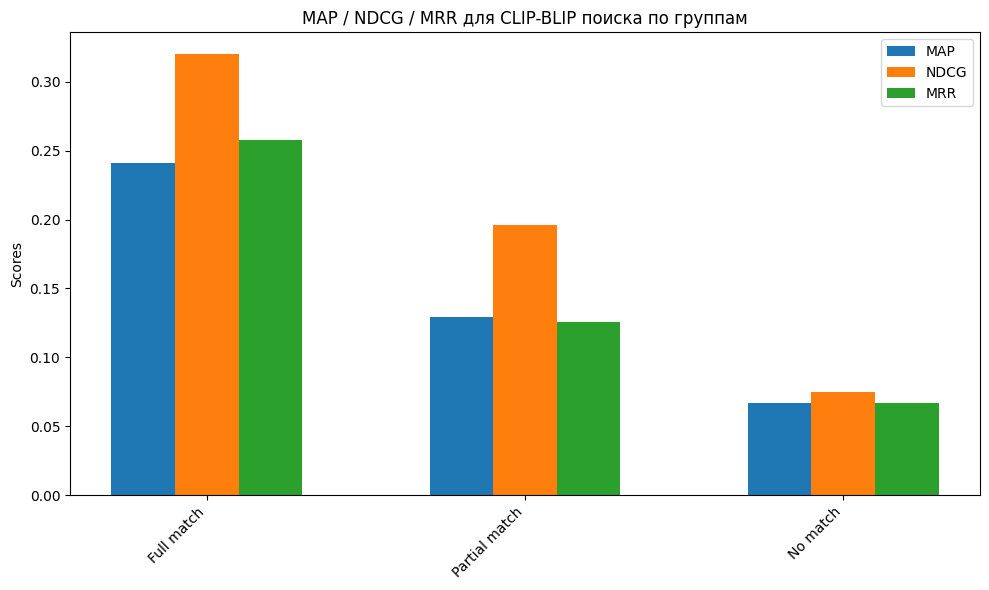

In [270]:
# --- 1. Утилиты CLIP/BLIP ---
def truncate_query(query: str, max_length: int = 76) -> str:
    tokens = clip_tokenizer.tokenize(query)
    if len(tokens) > max_length - 2:
        tokens = tokens[: max_length - 2]
    return clip_tokenizer.convert_tokens_to_string(tokens)

def retrieve_similar_images(query: str, k: int = 5):
    safe_q = truncate_query(query)
    inputs = clip_processor(text=safe_q, return_tensors="pt")
    with torch.no_grad():
        txt_feat = clip_model.get_text_features(**inputs)
    vec = txt_feat.cpu().numpy().astype("float32")
    distances, indices = clip_index.search(vec, k)

    results = []
    for idx, dist in zip(indices[0], distances[0]):
        img_path = clip_valid_paths[idx]
        caption  = blip_captions[idx]
        results.append((img_path, caption, dist))
    return results

# --- 2. Метрики ---
def average_precision(rels):
    ap, num_rel, cum_rel = 0.0, 0, 0
    for i, r in enumerate(rels):
        if r:
            num_rel += 1
            cum_rel += 1
            ap += cum_rel / (i + 1)
    return ap / num_rel if num_rel else 0.0

def ndcg_at_k(rels, k):
    dcg = rels[0] if rels else 0.0
    for i in range(1, min(len(rels), k)):
        dcg += rels[i] / math.log2(i + 2)
    ideal = sorted(rels, reverse=True)
    idcg  = ideal[0] if ideal else 0.0
    for i in range(1, min(len(ideal), k)):
        idcg += ideal[i] / math.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0

def weighted_mrr(rels):
    for i, r in enumerate(rels):
        if r:
            return 1.0 / (i + 1)
    return 0.0

# --- 3. Оценка одного запроса по картинкам ---
def evaluate_image_query(query: str, relevant_paths: list, k: int = 5):
    retrieved = retrieve_similar_images(query, k)
    retrieved_paths = [path for path, _, _ in retrieved]
    rels = [1 if p in relevant_paths else 0 for p in retrieved_paths]
    return (
        average_precision(rels),
        ndcg_at_k(rels, k),
        weighted_mrr(rels),
    )


# --- 5. Сбор метрик по группам ---
avg_metrics_img = {}
for grp, qs in groups.items():
    aps, ndcgs, mrrs = [], [], []
    for q, gt in zip(qs, ground_truth_img[grp]):
        ap, ndcg, mrr = evaluate_image_query(q, gt, k=5)
        aps.append(ap)
        ndcgs.append(ndcg)
        mrrs.append(mrr)
    avg_metrics_img[grp] = {
        "MAP":  np.mean(aps),
        "NDCG": np.mean(ndcgs),
        "MRR":  np.mean(mrrs),
    }

# --- 6. Визуализация ---
labels    = list(avg_metrics_img.keys())
map_vals  = [avg_metrics_img[l]["MAP"]  for l in labels]
ndcg_vals = [avg_metrics_img[l]["NDCG"] for l in labels]
mrr_vals  = [avg_metrics_img[l]["MRR"]  for l in labels]

x = np.arange(len(labels))
w = 0.2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - w, map_vals,  w, label='MAP')
ax.bar(x,     ndcg_vals, w, label='NDCG')
ax.bar(x + w, mrr_vals,  w, label='MRR')

ax.set_ylabel('Scores')
ax.set_title('MAP / NDCG / MRR для CLIP-BLIP поиска по группам')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
fig.tight_layout()
plt.show()

## Средние показатели асессорской разметки в RAG, где у новости нет текста, но есть изображение

In [119]:
news_image_captions = [
  "Какие люди сидят за столом с бумагами и ручками?",
  "Какие люди в красной униформе сидят за столом с бумагами?",
  "Что делает женщина, читающая книгу за столом, и где при этом находятся остальные люди?",
  "Как выглядит большой зал с высоты, в котором стоит статуя мужчины в костюме?",
  "Кто стоит на трибуне в военной форме рядом с флагами?",
  "Что делают люди в военной форме перед сценой?",
  "Какая диаграмма показывает количество людей, оплачивающих покупку дома?",
  "Как выглядит страница со скриншота, на которой дано текстовое описание мобильного телефона?",
  "Какие два мужчины и женщина стоят перед зданием?",
  "Как выглядит карта российского региона Пошма с высоты?",
  "Где на карте российской границы расположены основные города?",
  "Кто из трёх человек стоит за трибуной с микрофоном?",
  "Что держит блондинка на плакате с изображением мальчика и девочки?",
  "Кто стоит перед синим фоном в костюме и галстуке?",
  "Как хоккеисты празднуют гол перед зрительской толпой?",
  "Как проходит игра в хоккей на льду между командами?",
  "Как выглядит футболист в жёлто-синей форме на аэрофотоснимке?",
  "Что изображено на аэрофотоснимке: мужчина в костюме и галстуке на фоне статуи?",
  "Что делает мужчина на поле с футбольным мячом на аэрофотоснимке?",
  "Как игроки сборной по футболу на аэрофотоснимке показывают «палец вверх» вместе с товарищами по команде?"
]
news_image_captions

['Какие люди сидят за столом с бумагами и ручками?',
 'Какие люди в красной униформе сидят за столом с бумагами?',
 'Что делает женщина, читающая книгу за столом, и где при этом находятся остальные люди?',
 'Как выглядит большой зал с высоты, в котором стоит статуя мужчины в костюме?',
 'Кто стоит на трибуне в военной форме рядом с флагами?',
 'Что делают люди в военной форме перед сценой?',
 'Какая диаграмма показывает количество людей, оплачивающих покупку дома?',
 'Как выглядит страница со скриншота, на которой дано текстовое описание мобильного телефона?',
 'Какие два мужчины и женщина стоят перед зданием?',
 'Как выглядит карта российского региона Пошма с высоты?',
 'Где на карте российской границы расположены основные города?',
 'Кто из трёх человек стоит за трибуной с микрофоном?',
 'Что держит блондинка на плакате с изображением мальчика и девочки?',
 'Кто стоит перед синим фоном в костюме и галстуке?',
 'Как хоккеисты празднуют гол перед зрительской толпой?',
 'Как проходит иг

In [ ]:
# 1. Загрузка
with open("news_data2.json", encoding="utf-8") as f:
    raw = json.load(f)
df = pd.DataFrame(raw)
df.head(1)

old_text = ""
new_text = " "

# Заменяем None/NaN на пустую строку
df["text"] = df["text"].fillna("")

# Применяем replace только к тем строкам, у которых длина < 2
df["text"] = [
    path.replace(old_text, new_text) if len(path) < 2 else path
    for path in df["text"]
]

# 3. Предобработка
ru_stop = stopwords("ru")
def clean(text: str) -> str:
    text = BeautifulSoup(text, "html.parser").get_text(" ", strip=True)
    text = unicodedata.normalize("NFKC", text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    tokens = [t for t in text.split() if t not in ru_stop]
    return " ".join(tokens)
df["clean_text"] = df["text"].map(clean)


months = {
    '01': 'января', '02': 'февраля', '03': 'марта', '04': 'апреля',
    '05': 'мая', '06': 'июня', '07': 'июля', '08': 'августа',
    '09': 'сентября', '10': 'октября', '11': 'ноября', '12': 'декабря'
}
df['time_'] = df['time'].str.replace(
    r'(\d{2})\.(\d{2})\.\d{4}',
    lambda m: f"{int(m.group(1))} {months[m.group(2)]}",
    regex=True
)

df["clean_text"] = df["time_"] + " " + df["clean_text"]

df.head(1)

,category,channel,message_id,time,text,image_path,clean_text,time_
0,General news,@rian_ru,291023,25.04.2025,Разведка Индии на фоне обострения отношений с Пакистаном предупредила о возможности новых терактов в Джамму и Кашмире,,25 апреля разведка индии фоне обострения отношений пакистаном предупредила возможности новых терактов джамму кашмире,25 апреля


In [ ]:
from tqdm.auto import tqdm

def retrieve_similar_documents(search_text: str, k: int = 5):
    """Возвращает список из k наиболее релевантных текстовых фрагментов для заданного запроса."""
    search_vector = model.encode(search_text)
    new_vector = np.array([search_vector])
    faiss.normalize_L2(new_vector)
    distances, ann = text_index.search(new_vector, k=5)
    indices = ann[0]
    top_texts = df['clean_text'].iloc[indices].reset_index(drop=True)
    results = pd.DataFrame({
        'distances': distances[0],
        'clean_text': top_texts
    })
    return results

def truncate_query(query: str, max_length: int = 76) -> str:
    """
    Обрезает текстовый запрос до допустимой длины для CLIP-модели (максимум 77 токенов).
    """
    tokens = clip_tokenizer.tokenize(query)
    if len(tokens) > max_length - 2:  # учитываем специальные токены [CLS] и [SEP]
        tokens = tokens[:max_length - 2]
    return clip_tokenizer.convert_tokens_to_string(tokens)


def retrieve_similar_images(query: str, k: int = 5):
    """
    По заданному текстовому запросу с помощью CLIP модели
    ищет наиболее релевантные изображения из clip_index,
    после чего для найденных изображений возвращает соответствующие подписи (BLIP).
    Возвращается список кортежей (путь_к_изображению, подпись).
    """
    # Обрезаем запрос до допустимой длины
    safe_query = truncate_query(query)

    # Получаем текстовое представление запроса
    text_input = clip_processor(text=safe_query, return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_input)
    text_features = text_features.cpu().numpy().astype("float32")

    query_emb = model.encode([safe_query]).astype("float32")
    distances, indicesb = blip_index.search(query_emb, k) 
 
    # Поиск в CLIP индексе
    distances, indicesc = clip_index.search(text_features, k)
    retrieved = []
    for idxc, idxb in zip(indicesc[0], indicesb[0]):
        image_path = clip_valid_paths[idxc]
        caption = blip_captions[idxb]
        retrieved.append((image_path, caption))
    return retrieved



def generate_answer_with_images(query: str, top_text_k: int = 5, top_image_k: int = 5) -> str:
    # Получаем релевантные текстовые фрагменты по запросу
    context_chunks = retrieve_similar_documents(query, k=top_text_k)
    context_text = "\n\n".join(context_chunks["clean_text"])
    
    # Получаем релевантные изображения и их подписи
    # similar_images = retrieve_similar_images(query, k=top_image_k)
    # image_captions = [f" {caption}" for _, caption in similar_images]
    # images_context = "\n\n".join(image_captions)
    
    # Объединяем оба контекста
    final_context = context_text #+ "\n\n" + images_context
    
    prompt = (
        "Используя информацию из приведенного контекста, ответь на следующий вопрос.\n\n"
        f"Контекст:\n{final_context}\n\n"
        f"Вопрос: {query}\n\nОтвет:"
    )
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama-3.3-70b-versatile",
    )
    answer = response.choices[0].message.content
    return answer


# -------- 2. Готовим пустую таблицу --------
rows_none_text_adaptive_without_image_index = []

# -------- 3. Генерируем ответы --------
for q in tqdm(news_image_captions, leave=False):
    try:
        answer = generate_answer_with_images(q, top_text_k=5, top_image_k=3)
    except Exception as e:
        # если что‑то пошло не так, фиксируем ошибку и продолжаем
        answer = f"[ERROR]: {e}"
    rows_none_text_adaptive_without_image_index.append({
        "query":  q,
        "answer": answer,
    })

# -------- 4. Формируем DataFrame --------
rows_none_text_adaptive_without_image_index = pd.DataFrame(rows_none_text_adaptive_without_image_index)           # Jupyter‑ноутбук: красивый вывод
# или print(answers_df.head())

# -------- 5. (опционально) сохраняем на диск --------
rows_none_text_adaptive_without_image_index.to_csv("rows_none_text_adaptive_without_image_index.csv", index=False, encoding="utf-8")
print("✅  Таблица сохранена в файл rag_answers.csv")


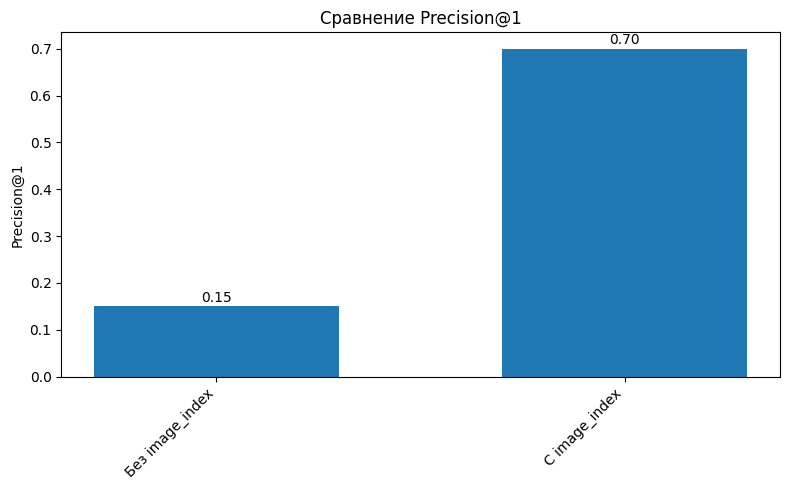

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Список файлов и соответствующих им меток
datasets = [
    ('rows_none_text_adaptive_without_image_index.csv', 'Без image_index'),
    ('rows_none_text_adaptive.csv', 'С image_index'),
]

scores = []
labels = []

for path, label in datasets:
    # Загружаем CSV и строим колонку relevance из строки
    df = pd.read_csv(f'/Applications/Study/Diploma/{path}')
    if 'without_image_index' in path:
        relevance_str = "10000000001000000010"
    else:
        relevance_str = "10111001001111110111"
    df['relevance'] = [int(ch) for ch in relevance_str]

    # Считаем Precision@1 и сохраняем
    score = np.mean(df['relevance'])
    scores.append(score)
    labels.append(label)

# Формируем DataFrame
metrics_df = pd.DataFrame({
    'Dataset': labels,
    'Precision@1': scores
})

# Построение сравнительного графика
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics_df))
ax.bar(x, metrics_df['Precision@1'], width=0.6)

ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Dataset'], rotation=45, ha='right')
ax.set_ylabel('Precision@1')
ax.set_title('Сравнение Precision@1')
for i, v in enumerate(metrics_df['Precision@1']):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center')

fig.tight_layout()
plt.show()

## Средние показатели асессорской разметки для text и image index в RAG

In [ ]:
from tqdm.auto import tqdm

def retrieve_similar_documents(search_text: str, k: int = 5):
    """Возвращает список из k наиболее релевантных текстовых фрагментов для заданного запроса."""
    search_vector = model.encode(search_text)
    new_vector = np.array([search_vector])
    faiss.normalize_L2(new_vector)
    distances, ann = text_index.search(new_vector, k=5)
    indices = ann[0]
    top_texts = df['clean_text'].iloc[indices].reset_index(drop=True)
    results = pd.DataFrame({
        'distances': distances[0],
        'clean_text': top_texts
    })
    return results

def truncate_query(query: str, max_length: int = 76) -> str:
    """
    Обрезает текстовый запрос до допустимой длины для CLIP-модели (максимум 77 токенов).
    """
    tokens = clip_tokenizer.tokenize(query)
    if len(tokens) > max_length - 2:  # учитываем специальные токены [CLS] и [SEP]
        tokens = tokens[:max_length - 2]
    return clip_tokenizer.convert_tokens_to_string(tokens)


def retrieve_similar_images(query: str, k: int = 5):
    """
    По заданному текстовому запросу с помощью CLIP модели
    ищет наиболее релевантные изображения из clip_index,
    после чего для найденных изображений возвращает соответствующие подписи (BLIP).
    Возвращается список кортежей (путь_к_изображению, подпись).
    """
    # Обрезаем запрос до допустимой длины
    safe_query = truncate_query(query)

    # Получаем текстовое представление запроса
    text_input = clip_processor(text=safe_query, return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_input)
    text_features = text_features.cpu().numpy().astype("float32")

    # Поиск в CLIP индексе
    distances, indices = clip_index.search(text_features, k)
    retrieved = []
    for idx in indices[0]:
        image_path = clip_valid_paths[idx]
        caption = blip_captions[idx]
        retrieved.append((image_path, caption))
    return retrieved



def generate_answer_with_images(query: str, top_text_k: int = 5, top_image_k: int = 3) -> str:
    # Получаем релевантные текстовые фрагменты по запросу
    context_chunks = retrieve_similar_documents(query, k=top_text_k)
    context_text = "\n\n".join(context_chunks["clean_text"])
    
    # Получаем релевантные изображения и их подписи
    similar_images = retrieve_similar_images(query, k=top_image_k)
    image_captions = [f"Подпись изображения: {caption}" for _, caption in similar_images]
    images_context = "\n\n".join(image_captions)
    
    # Объединяем оба контекста
    final_context = context_text + "\n\n" + images_context
    
    prompt = (
        "Используя информацию из приведенного контекста, ответь на следующий вопрос.\n\n"
        f"Контекст:\n{final_context}\n\n"
        f"Вопрос: {query}\n\nОтвет:"
    )
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama-3.3-70b-versatile",
    )
    answer = response.choices[0].message.content
    return answer

# -------- 2. Готовим пустую таблицу --------
rows = []

# -------- 3. Генерируем ответы --------
for group_name, queries in groups.items():
    print(f"▶️  Обрабатываем группу: {group_name}  ({len(queries)} вопросов)")
    for q in tqdm(queries, leave=False):
        try:
            answer = generate_answer_with_images(q, top_text_k=5, top_image_k=3)
        except Exception as e:
            # если что‑то пошло не так, фиксируем ошибку и продолжаем
            answer = f"[ERROR]: {e}"
        rows.append({
            "group":  group_name,
            "query":  q,
            "answer": answer,
        })

# -------- 4. Формируем DataFrame --------
answers_df = pd.DataFrame(rows)
display(answers_df)            # Jupyter‑ноутбук: красивый вывод
# или print(answers_df.head())

# -------- 5. (опционально) сохраняем на диск --------
answers_df.to_csv("rag_answers.csv", index=False, encoding="utf-8")
print("✅  Таблица сохранена в файл rag_answers.csv")

# # Пример запроса:
# user_question = "Что произошло 15 октября Чрезвычайный и Полномочный Посол России с дркгой страной?"
# answer = generate_answer_with_images(user_question, top_text_k=5, top_image_k=3)
# print("Ответ модели с учетом подписей изображений:\n", answer)

In [273]:
answers_df.head(1)

,group,query,answer
0,Full match,Когда срок моратория на удары по энергообъектам истек?,Срок моратория на удары по энергообъектам истек 15 апреля.


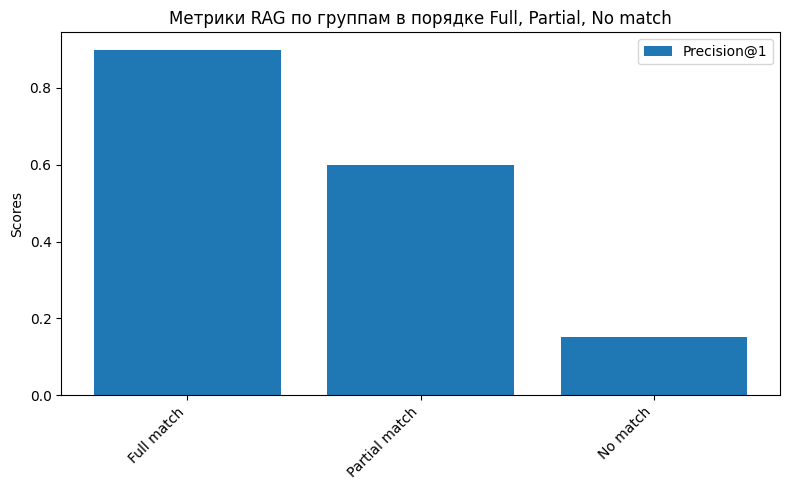

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Заново загружаем csv с ответами и relevance
df = pd.read_csv('/Applications/Study/Diploma/rag_answers.csv')
relevance_str = "110111111101111111111111110101100100110010000010000010000000"
df['relevance'] = [int(ch) for ch in relevance_str]

# Считаем метрики по группам
metrics = []
for group, group_df in df.groupby('group'):
    score = np.mean(group_df['relevance'])
    metrics.append({
        'group': group,
        'MAP@1': score,
        'NDCG@1': score,
        'MRR@1': score,
        'Precision@1': score
    })

metrics_df = pd.DataFrame(metrics)

# Желаемый порядок
order = ['Full match', 'Partial match', 'No match']
metrics_df = metrics_df.set_index('group').loc[order].reset_index()

# Строим график
labels = metrics_df['group'].tolist()
x = np.arange(len(labels))
w = 0.2

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x , metrics_df['Precision@1'], label='Precision@1')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Scores')
ax.set_title('Метрики RAG по группам в порядке Full, Partial, No match')
ax.legend()
fig.tight_layout()
plt.show()

In [304]:
def generate_answer_with_images(query: str, top_text_k: int = 5, top_image_k: int = 3) -> str:
    # Получаем релевантные текстовые фрагменты по запросу
    context_chunks = retrieve_similar_documents(query, k=top_text_k)
    context_text = "\n\n".join(context_chunks["clean_text"])
    
    # Получаем релевантные изображения и их подписи
    # similar_images = retrieve_similar_images(query, k=top_image_k)
    # image_captions = [f"Подпись изображения: {caption}" for _, caption in similar_images]
    # images_context = "\n\n".join(image_captions)
    
    # Объединяем оба контекста
    final_context = context_text #+ "\n\n" + images_context
    prompt = (
        "Используя информацию из приведенного контекста, ответь на следующий вопрос.\n\n"
        f"Контекст:\n{final_context}\n\n"
        f"Вопрос: {query}\n\nОтвет:"
    )
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama-3.3-70b-versatile",
    )
    answer = response.choices[0].message.content
    return answer

# -------- 2. Готовим пустую таблицу --------
rows_without_full = []

# -------- 3. Генерируем ответы --------
for group_name, queries in groups.items():
    print(f"▶️  Обрабатываем группу: {group_name}  ({len(queries)} вопросов)")
    for q in tqdm(queries, leave=False):
        try:
            answer = generate_answer_with_images(q, top_text_k=5, top_image_k=3)
        except Exception as e:
            # если что‑то пошло не так, фиксируем ошибку и продолжаем
            answer = f"[ERROR]: {e}"
        rows_without_full.append({
            "group":  group_name,
            "query":  q,
            "answer": answer,
        })

# -------- 4. Формируем DataFrame --------
answers_df_without_full = pd.DataFrame(rows_without_full)           # Jupyter‑ноутбук: красивый вывод
# или print(answers_df.head())

# -------- 5. (опционально) сохраняем на диск --------
answers_df_without_full.to_csv("rag_answers_without_full.csv", index=False, encoding="utf-8")
print("✅  Таблица сохранена в файл rag_answers.csv")

# # Пример запроса:
# user_question = "Что произошло 15 октября Чрезвычайный и Полномочный Посол России с дркгой страной?"
# answer = generate_answer_with_images(user_question, top_text_k=5, top_image_k=3)
# print("Ответ модели с учетом подписей изображений:\n", answer)

▶️  Обрабатываем группу: Full match  (20 вопросов)


▶️  Обрабатываем группу: Partial match  (20 вопросов)


▶️  Обрабатываем группу: No match  (20 вопросов)


✅  Таблица сохранена в файл rag_answers.csv


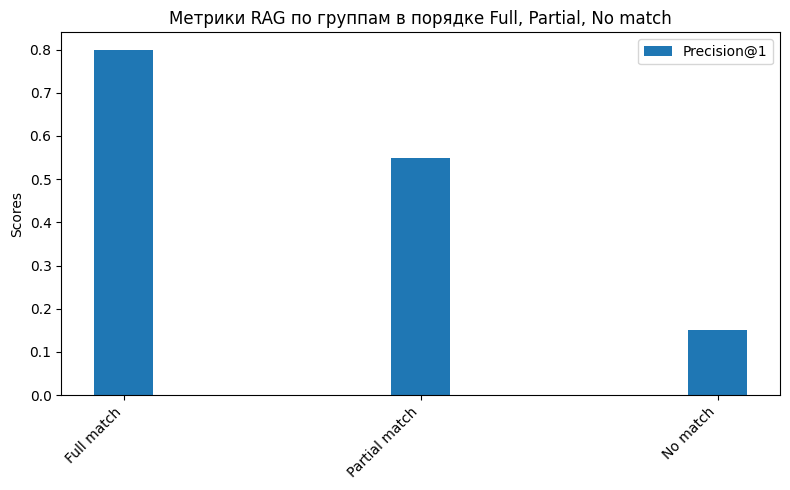

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Заново загружаем csv с ответами и relevance
df = pd.read_csv('/Applications/Study/Diploma/rag_answers_without_full.csv')
relevance_str = "110111111001111011111111000100100011110100100000000010000100"
df['relevance'] = [int(ch) for ch in relevance_str]

# Считаем метрики по группам
metrics = []
for group, group_df in df.groupby('group'):
    score = np.mean(group_df['relevance'])
    metrics.append({
        'group': group,
        'MAP@1': score,
        'NDCG@1': score,
        'MRR@1': score,
        'Precision@1': score
    })
metrics_df = pd.DataFrame(metrics)

# Желаемый порядок
order = ['Full match', 'Partial match', 'No match']
metrics_df = metrics_df.set_index('group').loc[order].reset_index()

# Строим график
labels = metrics_df['group'].tolist()
x = np.arange(len(labels))
w = 0.2

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x , metrics_df['Precision@1'], w, label='Precision@1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Scores')
ax.set_title('Метрики RAG по группам в порядке Full, Partial, No match')
ax.legend()
fig.tight_layout()
plt.show()

## Средние показатели асессорской разметки в RAG по категориям новостей

In [152]:
news_categories = {
  "politics": [
    "Какой населённый пункт в ДНР освободили российские войска 24 апреля 2025 года?",
    "В чём Дональд Трамп обвинил Киев 25 апреля 2025 года?",
    "К какому худшему сценарию готовилось правительство Украины в апреле 2025 года?",
    "Что сделало правительство Украины для упрощения импорта боеприпасов в апреле 2025 года?",
    "Какую инициативу внесли депутаты Госдумы РФ по поводу задолженности граждан в апреле 2025 года?",
    "Почему в Киргизии арестовали блогера Виктора Васильева в апреле 2025 года?",
    "С какой целью посол США Линн Трейси посещала Москву 25 апреля 2025 года?",
    "Что призвал сделать профсоюз силовых органов Молдавии в апреле 2025 года?",
    "В каком формате решили провести «Бессмертный полк» в Курской области в 2025 году?",
    "Какая патриотическая акция прошла 25 апреля 2025 года по всей России?",
    "Какие авиаудары нанесла Израиль в Йемене в начале мая 2025 года?",
    "Какую ракетную атаку на Израиль совершили хуситы в мае 2025 года?",
    "Какое решение принял израильский кабинет министров по сектору Газа в мае 2025 года?",
    "Какие страны нанесли ответные удары по Йемену во время кризиса на Красном море в мае 2025 года?",
    "Какое заявление сделал президент США Дональд Трамп об иммиграции в мае 2025 года?",
    "Продолжается ли вооружённый конфликт в Судане в мае 2025 года?",
    "Как изменилась свобода прессы в мире по данным на май 2025 года?",
    "Обсуждались ли новые санкции против России в мае 2025 года?",
    "Проводила ли Северная Корея испытания ракет в мае 2025 года?",
    "Были ли обострения в отношениях Китая и Тайваня в мае 2025 года?"
  ],
  "economy": [
    "Какое решение принял Центробанк России по ключевой ставке 25 апреля 2025 года?",
    "Как Набиуллина сравнила высокую ключевую ставку с лекарством для экономики?",
    "Кто приобрёл 50% компании Avito в апреле 2025 года?",
    "Что сообщил Минэнерго РФ о поставках газа в Иран в апреле 2025 года?",
    "Как поступила немецкая газета Münchner Merkur со статьями об Алишере Усманове в апреле 2025 года?",
    "Что заявила ООН о запасах продовольствия в секторе Газа в апреле 2025 года?",
    "Какое ограничение предложили ввести депутаты для курьеров в апреле 2025 года?",
    "Как отреагировал индекс МосБиржи на решение о ключевой ставке 25 апреля 2025 года?",
    "Какой совет туристам, планирующим поездку в Стамбул, был дан в апреле 2025 года?",
    "Наблюдался ли рост краж в магазинах Великобритании по данным на 2024 год?",
    "Что происходило с ценами на нефть в мае 2025 года?",
    "Каков был рост ВВП Китая в первом квартале 2025 года?",
    "Как изменилась стоимость биткоина в мае 2025 года?",
    "Какой уровень инфляции отмечался в России в мае 2025 года?",
    "Каков был уровень безработицы в США на апрель 2025 года?",
    "Кто были основными импортёрами российской нефти в 2025 году?",
    "Принимал ли Европейский центральный банк решения о ставке в мае 2025 года?",
    "Что решил ФРС США относительно процентной ставки в мае 2025 года?",
    "Каков был дефицит бюджета России к весне 2025 года?",
    "Как изменилась экономика Великобритании в первом квартале 2025 года?"
  ],
  "sports": [
    "С кем и когда сборная России по футболу проведет товарищеский матч, согласно новости от 25 апреля 2025 года?",
    "Почему футбольный матч «Аталанта» — «Лечче» был перенесён 24 апреля 2025 года?",
    "Как почтили память Папы Римского перед полуфинальными матчами еврокубков в апреле 2025 года?",
    "Какой российский хоккеист оформил хет-трик в Кубке Стэнли в апреле 2025 года?",
    "Кто выиграл многоборье на Кубке России по спортивной гимнастике в апреле 2025 года?",
    "Какое достижение удалось российской теннисистке Диане Шнайдер на турнире в Мадриде в апреле 2025 года?",
    "Что произошло с футболистом Павлом Мелёшиным в апреле 2025 года?",
    "Кто стал чемпионом Европы по дзюдо из россиян в апреле 2025 года?",
    "Какой тренер фигурировал в слухах о назначении в «РБ Лейпциг» в апреле 2025 года?",
    "Почему испанская теннисистка Паула Бадоса снялась с турнира в Мадриде в апреле 2025 года?",
    "Какая команда стала чемпионом Англии по футболу в сезоне 2024/2025?",
    "Какие команды вышли в финал Лиги чемпионов 2025 года?",
    "В какой стране проходит чемпионат мира по хоккею 2025 года?",
    "Когда начинается турнир Большого шлема Ролан Гаррос 2025 года?",
    "Какие команды вышли в финал НБА сезона 2024/2025?",
    "Кто получил приз MVP в НБА по итогам сезона 2024/2025?",
    "Какие команды сыграют в финале Кубка Стэнли 2025 года?",
    "Кто победил в гонке Формулы-1 Гран-при Монако 2025 года?",
    "Кто выиграл чемпионат мира по снукеру 2025 года?",
    "Где и когда пройдет финал футбольной Лиги Европы 2025 года?"
  ],
  "entertainment": [
    "Какой фильм получил главный приз Московского международного кинофестиваля 2025 года?",
    "Как называется фильм, представленный режиссёром Тиграном Кеосаяном в апреле 2025 года?",
    "Какое наказание получил концертный директор Игоря Талькова в апреле 2025 года?",
    "Чья церемония прощания состоялась в храме Христа Спасителя 23 апреля 2025 года?",
    "Когда пройдёт конкурс Интервидение в 2025 году?",
    "Где выступил Иван Ургант со своим шоу в апреле 2025 года?",
    "Какой российский певец получил премию «Шансон» в Германии в апреле 2025 года?",
    "Как называется новый фильм о Хищнике, трейлер которого показали в апреле 2025 года?",
    "Что объявили организаторы фестиваля Comic Con Russia в апреле 2025 года?",
    "Какую знаменитую роль выразил готовность снова исполнить актёр Эндрю Гарфилд в апреле 2025 года?",
    "В какой стране проходил конкурс Евровидение-2025?",
    "Кто выиграл конкурс Евровидение-2025?",
    "Какой фильм получил Золотую пальмовую ветвь Каннского фестиваля 2025 года?",
    "Какая тема была выбрана для Met Gala в 2025 году?",
    "Какой фильм возглавил мировой кинопрокат в мае 2025 года?",
    "Какой фильм получил премию Оскар за лучший фильм в 2025 году?",
    "Кто получил премию Оскар за лучшую мужскую роль в 2025 году?",
    "Когда ожидается выход фильма 'Аватар 3' и что о нём известно?",
    "Какой известный музыкант объявил о мировом турне в 2025 году?",
    "Принимала ли Россия участие в конкурсе Евровидение-2025?"
  ],
  "science": [
    "Какое изменение в русском языке предсказывают учёные в отношении ударения слова 'звонит'?",
    "Какую комету наблюдали астрономы в апреле 2025 года?",
    "Какое извержение вулкана произошло на Камчатке в апреле 2025 года?",
    "Какое опасное заболевание выявили в Московской области в апреле 2025 года?",
    "Какой новый самолёт совершил первый полёт с отечественными комплектующими в апреле 2025 года?",
    "Для борьбы с каким растением был создан специальный дрон в России в 2025 году?",
    "Что показало исследование о психологической совместимости в отношениях россиян в апреле 2025 года?",
    "Как большинство россиян относятся к рождению детей подростками по данным опроса 2025 года?",
    "Как изменилась продолжительность зимы в Арктике по данным исследований к 2025 году?",
    "Какое крупное лесное пожарище произошло в штате Нью-Джерси в апреле 2025 года?",
    "Когда запланирована миссия Artemis II с облётом Луны?",
    "Какое важное открытие сделал космический телескоп Джеймса Уэбба к 2025 году?",
    "Как используется искусственный интеллект в медицине в 2025 году?",
    "Какой температурный рекорд был зафиксирован в мире к 2025 году?",
    "Каких успехов удалось добиться в области термоядерного синтеза к 2025 году?",
    "Совершила ли ракета SpaceX Starship успешный орбитальный полёт к маю 2025 года?",
    "Какова ситуация с пандемией COVID-19 в мире к 2025 году?",
    "До какого года планируется эксплуатация Международной космической станции?",
    "Где пройдёт климатическая конференция ООН (COP-30) в 2025 году?",
    "Начаты ли испытания мобильной связи шестого поколения (6G) к 2025 году?"
  ]
}

In [155]:
from tqdm.auto import tqdm

def retrieve_similar_documents(search_text: str, k: int = 5):
    """Возвращает список из k наиболее релевантных текстовых фрагментов для заданного запроса."""
    search_vector = model.encode(search_text)
    new_vector = np.array([search_vector])
    faiss.normalize_L2(new_vector)
    distances, ann = text_index.search(new_vector, k=5)
    indices = ann[0]
    top_texts = df['clean_text'].iloc[indices].reset_index(drop=True)
    results = pd.DataFrame({
        'distances': distances[0],
        'clean_text': top_texts
    })
    return results

def truncate_query(query: str, max_length: int = 76) -> str:
    """
    Обрезает текстовый запрос до допустимой длины для CLIP-модели (максимум 77 токенов).
    """
    tokens = clip_tokenizer.tokenize(query)
    if len(tokens) > max_length - 2:  # учитываем специальные токены [CLS] и [SEP]
        tokens = tokens[:max_length - 2]
    return clip_tokenizer.convert_tokens_to_string(tokens)


def retrieve_similar_images(query: str, k: int = 5):
    """
    По заданному текстовому запросу с помощью CLIP модели
    ищет наиболее релевантные изображения из clip_index,
    после чего для найденных изображений возвращает соответствующие подписи (BLIP).
    Возвращается список кортежей (путь_к_изображению, подпись).
    """
    # Обрезаем запрос до допустимой длины
    safe_query = truncate_query(query)

    # Получаем текстовое представление запроса
    text_input = clip_processor(text=safe_query, return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_input)
    text_features = text_features.cpu().numpy().astype("float32")

    query_emb = model.encode([safe_query]).astype("float32")
    distances, indicesb = blip_index.search(query_emb, k) 
 
    # Поиск в CLIP индексе
    distances, indicesc = clip_index.search(text_features, k)
    retrieved = []
    for idxc, idxb in zip(indicesc[0], indicesb[0]):
        image_path = clip_valid_paths[idxc]
        caption = blip_captions[idxb]
        retrieved.append((image_path, caption))
    return retrieved



def generate_answer_with_images(query: str, top_text_k: int = 5, top_image_k: int = 5) -> str:
    # Получаем релевантные текстовые фрагменты по запросу
    context_chunks = retrieve_similar_documents(query, k=top_text_k)
    context_text = "\n\n".join(context_chunks["clean_text"])
    
    # Получаем релевантные изображения и их подписи
    # similar_images = retrieve_similar_images(query, k=top_image_k)
    # image_captions = [f" {caption}" for _, caption in similar_images]
    # images_context = "\n\n".join(image_captions)
    
    # Объединяем оба контекста
    final_context = context_text #+ "\n\n" + images_context
    
    prompt = (
        "Используя информацию из приведенного контекста, ответь на следующий вопрос.\n\n"
        f"Контекст:\n{final_context}\n\n"
        f"Вопрос: {query}\n\nОтвет:"
    )
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama-3.3-70b-versatile",
    )
    answer = response.choices[0].message.content
    return answer


# -------- 2. Готовим пустую таблицу --------
rows_categories_news = []

# -------- 3. Генерируем ответы --------
for category, queries in tqdm(news_categories.items(), leave=False):
    for q in tqdm(queries, leave=False):
        try:
            answer = generate_answer_with_images(q, top_text_k=5, top_image_k=3)
        except Exception as e:
            # Если возникла ошибка, фиксируем её и продолжаем
            answer = f"[ERROR]: {e}"

        rows_categories_news.append({
            "category": category,
            "query": q,
            "answer": answer,
        })

# -------- 4. Формируем DataFrame --------
rows_categories_news = pd.DataFrame(rows_categories_news)           # Jupyter‑ноутбук: красивый вывод
# или print(answers_df.head())

# -------- 5. (опционально) сохраняем на диск --------
rows_categories_news.to_csv("rows_categories_news.csv", index=False, encoding="utf-8")
print("✅  Таблица сохранена в файл rows_categories_news.csv")


✅  Таблица сохранена в файл rows_categories_news.csv


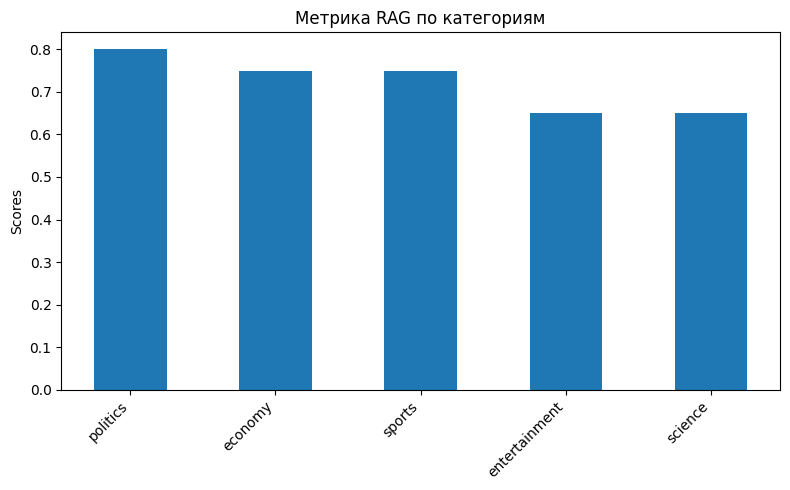

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загружаем csv с ответами и relevance
df = pd.read_csv('/Applications/Study/Diploma/rows_categories_news.csv')
relevance_str = "0110111111111111010111111110111011010110101101111001111110111011001110111111010011110101110010111010"
df['relevance'] = [int(ch) for ch in relevance_str]

# Расчёт метрик по группам
metrics = []
for group, group_df in df.groupby('category'):
    score = np.mean(group_df['relevance'])
    metrics.append({
        'category': group,
        'm': score,
    })

metrics_df = pd.DataFrame(metrics)

# Упорядочивание категорий
order = ['politics', 'economy', 'sports', 'entertainment', 'science']
metrics_df = metrics_df.set_index('category').loc[order].reset_index()

# График
labels = metrics_df['category'].tolist()
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, metrics_df['m'], width=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Scores')
ax.set_title('Метрика RAG по категориям')


fig.tight_layout()
plt.show()
